# Recreating https://arxiv.org/pdf/1608.02609.pdf first for $\rho$-$\rho$ decays

## Inputs:
- Invariant masses of intermediate resonances  
- Acoplanarity angles
- Variables $y_i^+$ ($y_k^-$)
- 4 momentum of visible decay products
- 4 momentum of intermediate resonances
    - If cascade decays, need to provide 4-momenta of all $\pi^+\pi^-$ pairs which can form the resonances
- Need to boost all four vectors where primary resonances are aligned along the z-axis.
- Normalise all features

In [10]:
import uproot 
import numpy as np
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

from pylorentz import Momentum4
from pylorentz import Position4
from lbn_modified import LBN, LBNLayer
from ROOT import TLorentzVector, TVector3

In [11]:
tree_tt = uproot.open("/eos/user/k/kgalambo/SWAN_projects/Masters_CP_Kristof_2/MVAFILE_AllHiggs_tt.root")["ntuple"]

variables = [
            "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
            "aco_angle_1", 
            "mva_dm_1","mva_dm_2",
            "tau_decay_mode_1","tau_decay_mode_2",
        #     "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
            "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", 
            "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", 
            "pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1",
            "pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2", 
            "y_1_1", "y_1_2"
        ]

In [80]:
# this line takes a long time!
df = tree_tt.pandas.df(variables)

In [81]:
print(set(df['mva_dm_1']))
print(set(df['mva_dm_2']))
print(set(df['tau_decay_mode_1']))
print(set(df['tau_decay_mode_2']))

{0, 1, 2, 10, 11, -1}
{0, 1, 2, 10, 11, -1}
{0, 1, 10, 11}
{0, 1, 10, 11}


In [82]:
# select only rho-rho events
df = df[(df['mva_dm_1']==1) & (df['mva_dm_2']==1) & (df["tau_decay_mode_1"] == 1) & (df["tau_decay_mode_2"] == 1)]

In [88]:
# create labels y
#binary
#y = (~(df["rand"]<df["wt_cp_ps"]/2).to_numpy()).astype(int)
#non-binary
y = df["wt_cp_sm"] / (df["wt_cp_ps"] + df["wt_cp_sm"])

In [ ]:
# drop unnecessary labels 
df = df.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)

In [15]:
df.head()

,aco_angle_1,pi_E_1,pi_px_1,pi_py_1,pi_pz_1,pi_E_2,pi_px_2,pi_py_2,pi_pz_2,pi0_E_1,pi0_px_1,pi0_py_1,pi0_pz_1,pi0_E_2,pi0_px_2,pi0_py_2,pi0_pz_2,y_1_1,y_1_2
0,2.657029,45.423448,-13.747046,-38.825621,-19.153590,35.805782,8.526798,34.653880,2.904638,10.039846,-3.551914,-8.385803,-4.224041,6.112238,1.959179,5.735656,0.777900,-0.637964,-0.708372
1,1.547246,24.506373,-14.056253,9.809321,-17.514046,19.587723,8.539313,-3.149378,-17.344192,41.244844,-24.443820,15.370633,-29.451014,77.036002,32.655902,-12.032904,-68.726477,0.254573,0.594557
2,3.750274,15.319610,8.794122,0.774085,12.519393,17.469988,-9.876231,-3.253855,14.037575,69.457213,38.899682,2.503120,57.487698,56.810782,-32.919951,-10.831700,45.015529,0.638590,0.529623
3,1.192612,94.211361,42.942276,-33.711103,-76.780750,3.656937,-2.129749,0.251363,-2.958835,25.585962,11.770386,-8.993712,-20.861314,68.839211,-41.770362,4.326843,-54.546623,-0.572846,0.899114
4,3.264792,25.899289,-22.245884,-12.141924,-5.333670,23.795390,21.402816,9.436143,-4.368043,23.216735,-20.268636,-10.296444,-4.707891,18.242053,16.607666,6.693405,-3.483969,-0.054617,-0.132105


- [x] calculate 4 momentum of resonances
- [x] calculate invariant mass of resonances m^2 = E^2 - p^2
- [ ] cascades?

In [16]:
# parse particle information
#columns = ['E', 'px', 'py', 'pz']

pi_1 = df[['pi_E_1', "pi_px_1", "pi_py_1", "pi_pz_1"]].to_numpy()
pi_2 = df[['pi_E_2', "pi_px_2", "pi_py_2", "pi_pz_2"]].to_numpy()
pi0_1 = df[['pi0_E_1', "pi0_px_1", "pi0_py_1", "pi0_pz_1"]].to_numpy()
pi0_2 = df[['pi0_E_2', "pi0_px_2", "pi0_py_2", "pi0_pz_2"]].to_numpy()

In [17]:
# reconstruct resonance 4 momentum
rho_1 = pi_1 + pi0_1
rho_2 = pi_2 + pi0_2

In [18]:
# calculate invariate masses
rho_1_m = (rho_1[:, 0]**2 - rho_1[:, 1]**2 - rho_1[:, 2]**2 - rho_1[:, 3]**2)**0.5
rho_2_m = (rho_2[:, 0]**2 - rho_2[:, 1]**2 - rho_2[:, 2]**2 - rho_2[:, 3]**2)**0.5

In [19]:
p3 = Momentum4(pi_1[:, 0], pi_1[:, 1], pi_1[:, 2], pi_1[:, 3])
p4 = Momentum4(pi_2[:, 0], pi_2[:, 1], pi_2[:, 2], pi_2[:, 3])
p1 = Momentum4(pi0_1[:, 0], pi0_1[:, 1], pi0_1[:, 2], pi0_1[:, 3])
p2 = Momentum4(pi0_2[:, 0], pi0_2[:, 1], pi0_2[:, 2], pi0_2[:, 3])
r1 = p1 + p3
r2 = p2 + p4
rest_frame = p1 + p2 + p3 + p4

In [20]:
#p1_boosted = p1.boost_particle(-r1)
#p3_boosted = p3.boost_particle(-r1)
#p2_boosted = p2.boost_particle(-r2)
#p4_boosted = p4.boost_particle(-r2)

p1_boosted = p1.boost_particle(-rest_frame)
p3_boosted = p3.boost_particle(-rest_frame)
p2_boosted = p2.boost_particle(-rest_frame)
p4_boosted = p4.boost_particle(-rest_frame)

r1_boosted = p1_boosted + p3_boosted
r2_boosted = p2_boosted + p4_boosted

## Rotations

The rotations are done as follows:

- calculate unit vectors along the 3-momenta

- calculate the axes which are perpendicular to the z-axis and the unit vectors

- rotate the 3-momenta about these axes by the angle between the z-axis and the unit vectors

In [21]:
#unit vectors along the momenta of the primary resonances
unit1 = (r1_boosted[1:, :] / np.linalg.norm(r1_boosted[1:, :], axis=0)).transpose()
unit2 = (r2_boosted[1:, :] / np.linalg.norm(r2_boosted[1:, :], axis=0)).transpose()

In [22]:
# probably there's a faster way of doing this
zaxis = np.array([np.array([0., 0., 1.]) for _ in range(len(unit1))])

In [23]:
axes1 = np.cross(unit1, zaxis)
axes2 = np.cross(unit2, zaxis)

In [24]:
dotproduct1 = (unit1*zaxis).sum(1)
angles1 = np.arccos(dotproduct1)
dotproduct2 = (unit2*zaxis).sum(1)
angles2 = np.arccos(dotproduct2)

In [25]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def rotate(vect, axis, theta):
    return np.dot(rotation_matrix(axis, theta), vect)

test_vector = [1, 0, 0]
test_axis = [0, 1, 0]
test_angle = np.pi/2

print('The rotated test_vector is:')
print(rotate(test_vector, test_axis, test_angle))

The rotated test_vector is:
[ 2.22044605e-16  0.00000000e+00 -1.00000000e+00]


In [26]:
# it would be nice to be able to do the rotation in a vectorized form, like this:
#p1rot = rotate(p1_boosted[1:, :].transpose(), axes1, angles1)

p1rot = []
p2rot = []
p3rot = []
p4rot = []
for i in range(p1_boosted[:].shape[1]):
    p1rot.append(rotate(p1_boosted[1:, i], axes1[i], angles1[i]))
    p2rot.append(rotate(p2_boosted[1:, i], axes1[i], angles1[i]))
    p3rot.append(rotate(p3_boosted[1:, i], axes1[i], angles1[i]))
    p4rot.append(rotate(p4_boosted[1:, i], axes1[i], angles1[i]))
    if i%100000==0:
        print('finished rotating 3-vector', i)
p1rot = np.array(p1rot)
p2rot = np.array(p2rot)
p3rot = np.array(p3rot)
p4rot = np.array(p4rot)

finished rotating 3-vector 0
finished rotating 3-vector 100000
finished rotating 3-vector 200000
finished rotating 3-vector 300000
finished rotating 3-vector 400000
finished rotating 3-vector 500000
finished rotating 3-vector 600000


In [27]:
# this should be vectorized as well
p1_rotated = []
p2_rotated = []
p3_rotated = []
p4_rotated = []
for i in range(p1_boosted[:].shape[1]):
    p1_rotated.append([p1_boosted[0, i], p1rot[i, 0], p1rot[i, 1], p1rot[i, 2]])
    p2_rotated.append([p2_boosted[0, i], p2rot[i, 0], p2rot[i, 1], p2rot[i, 2]])
    p3_rotated.append([p3_boosted[0, i], p3rot[i, 0], p3rot[i, 1], p3rot[i, 2]])
    p4_rotated.append([p4_boosted[0, i], p4rot[i, 0], p4rot[i, 1], p4rot[i, 2]])
    if i%100000==0:
        print('finished getting rotated 4-vector', i)
p1_rotated = np.array(p1_rotated).transpose()
p2_rotated = np.array(p2_rotated).transpose()
p3_rotated = np.array(p3_rotated).transpose()
p4_rotated = np.array(p4_rotated).transpose()

finished getting rotated 4-vector 0
finished getting rotated 4-vector 100000
finished getting rotated 4-vector 200000
finished getting rotated 4-vector 300000
finished getting rotated 4-vector 400000
finished getting rotated 4-vector 500000
finished getting rotated 4-vector 600000


In [28]:
#check rotations
print(p1_rotated.shape)
print(np.nanmax(p1_rotated[1, :] + p3_rotated[1, :]))
print(np.nanmax(p2_rotated[1, :] + p4_rotated[1, :]))

print(np.nanmax((p1_rotated[3, :] + p3_rotated[3, :]) - (p2_rotated[3, :] + p4_rotated[3, :])))

print('The first few boosted and rotated 4-vectors of pi_1 is:')
print(p3_rotated[1:, 0:10].transpose())

(4, 653528)
1.2899681323119694e-12
6.278533248860185e-12
1191.230810973787
The first few boosted and rotated 4-vectors of pi_1 is:
[[ 3.80031346e-01 -2.40221580e-01  3.88633983e+01]
 [ 3.43116131e-01  3.84715978e-01  1.71668456e+01]
 [-2.83708649e-01  4.96199492e-02  8.52098538e+00]
 [-1.06539667e-01 -1.10185212e-01  4.18362165e+01]
 [ 2.70168612e-01 -2.33073683e-01  2.34526166e+01]
 [ 2.93718273e-02 -2.36750549e-01  5.75406667e+00]
 [ 4.62458582e-02  1.75440068e-01  3.98863396e+01]
 [ 2.66187229e-01  1.02537116e-01  1.04857179e+01]
 [ 1.36384396e-01 -3.41001429e-01  1.81292853e+01]
 [ 1.85025944e-01  1.97250644e-01  2.22593776e+01]]


### Results of the rotations:

With the first version of boosting:

The first boosted and rotated 4-vector of pi_1 is:

[-0.61099598  0.53500495  0.25445607  0.05357516]

With Stanley's version of boosting:

The first boosted and rotated 4-vector of pi_1 is:

[-38.86624918   0.38003135  -0.24022158  38.8633983 ]

## The neural net

The inputs of these neural nets are the following:

- aco_angle_1

- y_1_1 and y_1_2

- the primary resonance masses

- the unrotated, or the rotated 4-vectors, or no 4-vectors at all

In [29]:
# create features and labels

aco_angle_1 = df['aco_angle_1'].to_numpy()
y_1_1 = df['y_1_1'].to_numpy()
y_1_2 = df['y_1_2'].to_numpy()

# this will use the unrotated, boosted 4-vectors:
E1 = p1_boosted[0]
px1 = p1_boosted[1]
py1 = p1_boosted[2]
pz1 = p1_boosted[3]
E2 = p2_boosted[0]
px2 = p2_boosted[1]
py2 = p2_boosted[2]
pz2 = p2_boosted[3]
E3 = p3_boosted[0]
px3 = p3_boosted[1]
py3 = p3_boosted[2]
pz3 = p3_boosted[3]
E4 = p4_boosted[0]
px4 = p4_boosted[1]
py4 = p4_boosted[2]
pz4 = p4_boosted[3]

# this will use the rotated, boosted 4-vectors:
E1r = p1_rotated[0]
px1r = p1_rotated[1]
py1r = p1_rotated[2]
pz1r = p1_rotated[3]
E2r = p2_rotated[0]
px2r = p2_rotated[1]
py2r = p2_rotated[2]
pz2r = p2_rotated[3]
E3r = p3_rotated[0]
px3r = p3_rotated[1]
py3r = p3_rotated[2]
pz3r = p3_rotated[3]
E4r = p4_rotated[0]
px4r = p4_rotated[1]
py4r = p4_rotated[2]
pz4r = p4_rotated[3]

# y is defined earlier

In [30]:
# if it gives the same accuracy score with the 4-vectors and without them, that's bad
## with the unrotated 4-vectors:
#X = np.stack([rho_1_m, rho_2_m, E1, px1, py1, pz1, E2, px2, py2, pz2, E3, px3, py3, pz3, E4, px4, py4, pz4, aco_angle_1, y_1_1, y_1_2], axis=1)
# with the rotated 4-vectors:
X = np.stack([rho_1_m, rho_2_m, E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r, aco_angle_1, y_1_1, y_1_2], axis=1)
## without the 4-vectors:
#X = np.stack([rho_1_m, rho_2_m, aco_angle_1, y_1_1, y_1_2], axis=1)

In [31]:
# for some reason there are about 30,000 nan values in X
print(np.argwhere(np.isnan(X)))

[]


In [32]:
## will debug this tomorrow
## this would remove the nans from the feature and the label set
#nan_mask = np.isnan(X)
#nan_mask_y = np.array([x.any() for x in nan_mask])
#print(nan_mask_y.shape)
#print(y.shape)
#print(X.shape)
#X = X[~nan_mask].reshape((-1, 21))
#y = y[~nan_mask_y]
#print(X.shape)

In [33]:
print(y.shape)
print(X.shape)
print('The number of samples should be the same in X and y!')

(653528,)
(653528, 21)
The number of samples should be the same in X and y!


In [34]:
# split X and y into train and validation dataset 

X_train, X_test, y_train, y_test  = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=123456,
    #stratify=y.values,
)

In [60]:
# define a simple NN
def baseline_model(dimensions=-1):
    if dimensions == -1:
        dimensions = X.shape[1]
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(38, input_dim=dimensions, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam')  
    return model

In [36]:
# define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [37]:
# first run the training for simple case with just 1 variable
history = tf.keras.callbacks.History()

model = baseline_model()

model.fit(
                X_train, y_train,
                batch_size=10000,
                epochs=20,
                callbacks=[history,early_stop],
                validation_data=(X_test, y_test))

W1108 15:28:08.133436 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7ff0b184e3b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/53 [===========================>..] - ETA: 0s - loss: 0.6954

W1108 15:28:10.663721 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff0b18b5a70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 2s 38ms/step - loss: 0.6950 - val_loss: 0.6872
Epoch 2/20
53/53 [==============================] - 2s 34ms/step - loss: 0.6853 - val_loss: 0.6842
Epoch 3/20
53/53 [==============================] - 2s 36ms/step - loss: 0.6832 - val_loss: 0.6827
Epoch 4/20
53/53 [==============================] - 2s 33ms/step - loss: 0.6823 - val_loss: 0.6821
Epoch 5/20
53/53 [==============================] - 2s 36ms/step - loss: 0.6819 - val_loss: 0.6820
Epoch 6/20
53/53 [==============================] - 2s 36ms/step - loss: 0.6818 - val_loss: 0.6820
Epoch 7/20
53/53 [==============================] - 2s 33ms/step - loss: 0.6816 - val_loss: 0.6824
Epoch 8

2020-11-08 15:28:07.769851: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-11-08 15:28:07.809940: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400135000 Hz
2020-11-08 15:28:07.814315: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4183f0a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-08 15:28:07.814392: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


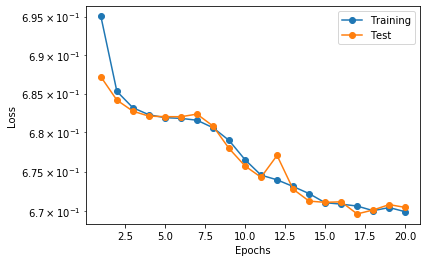

In [38]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract loss on training and validation ddataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Test")
plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

In [39]:
prediction = model.predict(X_test)

W1108 15:28:47.798884 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7ff1b00903b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [40]:
y_pred = [int(round(x)) for x in prediction.flatten()]

In [41]:
print('The accuracy score is: {:.4f}'.format(accuracy_score(y_test, y_pred)))

The accuracy score is: 0.5873


In [63]:
#  define a function to plot the ROC curves - just makes the roc_curve look nicer than the default
def plot_roc_curve(fpr, tpr, auc, config_num=-1):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid()
    ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
            bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.savefig('paper_2016/roc_rho_rho_NN_config_' + str(config_num))

W1108 15:28:50.925851 140680596404032 deprecation.py:323] From <ipython-input-43-d2f51cee44de>:2: Sequential.predict_proba (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.


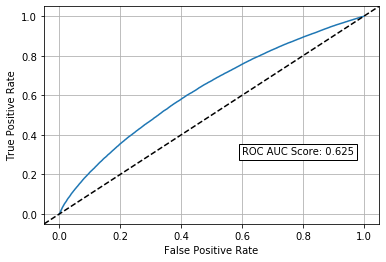

In [43]:
# plot ROC curve for improved training
y_proba = model.predict_proba(X_test) # outputs two probabilties
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plot_roc_curve(fpr, tpr, auc)

## Results of the neural net with the different configurations

Run the code with different configurations and record the ROC AUC scores

In [93]:
def load_config(i):
    if i==1:
        X = np.reshape(aco_angle_1, (-1, 1))
        #print('SHAPE:')
        #print(X.shape)
    if i==2:
        X = np.stack([aco_angle_1, y_1_1, y_1_2], axis=1)
        #print('SHAPE:')
        #print(X.shape)
    if i==3:
        X = np.stack([E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r], axis=1)
    if i==4:
        X = np.stack([aco_angle_1, E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r], axis=1)
    if i==5:
        X = np.stack([rho_1_m**2, rho_2_m**2, aco_angle_1, y_1_1, y_1_2], axis=1)
    if i==6:
        X = np.stack([rho_1_m**2, rho_2_m**2, E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r, aco_angle_1, y_1_1, y_1_2], axis=1)
    return X

def run_config(config_num):
    X = load_config(config_num)

    # split X and y into train and validation dataset 

    X_train, X_test, y_train, y_test  = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=123456,
        #stratify=y.values,
    )
    
    # define early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
    
    # first run the training for simple case with just 1 variable
    history = tf.keras.callbacks.History()

    model = baseline_model(X.shape[1])

    model.fit(
                    X_train, y_train,
                    batch_size=10000,
                    epochs=20,
                    callbacks=[history,early_stop],
                    validation_data=(X_test, y_test))
    
    # Extract number of run epochs from the training history
    epochs = range(1, len(history.history["loss"])+1)

    # Extract loss on training and validation ddataset and plot them together
    plt.plot(epochs, history.history["loss"], "o-", label="Training")
    plt.plot(epochs, history.history["val_loss"], "o-", label="Test")
    plt.xlabel("Epochs"), plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.savefig('paper_2016/history_nonbinary_config_' + str(config_num))
    
    prediction = model.predict(X_test)
    
    # plot ROC curve for improved training
    y_proba = model.predict_proba(X_test) # outputs two probabilties
    y_binary = (y_test > 0.5) * 1.0
    auc = roc_auc_score(y_binary, y_proba)
    fpr, tpr, _ = roc_curve(y_binary, y_proba)
    plot_roc_curve(fpr, tpr, auc, 'nonbinary' + str(config_num))
    
    f = open('paper_2016/auc_nonbinary.txt', 'a')
    f.write(str(config_num) + ',' + str(auc) + '\n')
    f.close()

W1108 16:48:47.927810 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7ff1641264d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/53 [===========================>..] - ETA: 0s - loss: 0.6923- ETA: 0s - loss: 0.692

W1108 16:48:50.332876 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff1672aeb90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 2s 36ms/step - loss: 0.6922 - val_loss: 0.6899
Epoch 2/20
53/53 [==============================] - 2s 31ms/step - loss: 0.6848 - val_loss: 0.6809
Epoch 3/20
53/53 [==============================] - 2s 31ms/step - loss: 0.6803 - val_loss: 0.6803
Epoch 4/20
53/53 [==============================] - 2s 31ms/step - loss: 0.6803 - val_loss: 0.6803
Epoch 5/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6803 - val_loss: 0.6803
Epoch 6/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6803 - val_loss: 0.6803
Epoch 7/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6803 - val_loss: 0.6803
Epoch 8

W1108 16:49:15.446305 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7ff18c04ee60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1108 16:49:21.084993 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7ff16747a950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/53 [===========================>..] - ETA: 0s - loss: 0.6902

W1108 16:49:23.383550 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff1670829e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 2s 35ms/step - loss: 0.6900 - val_loss: 0.6846
Epoch 2/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6815 - val_loss: 0.6803
Epoch 3/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6800 - val_loss: 0.6799
Epoch 4/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6798 - val_loss: 0.6798
Epoch 5/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6796 - val_loss: 0.6796
Epoch 6/20
53/53 [==============================] - 2s 28ms/step - loss: 0.6795 - val_loss: 0.6795
Epoch 7/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6793 - val_loss: 0.6793
Epoch 8

W1108 16:49:55.900152 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7ff1644d7680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1108 16:50:01.221797 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7ff164602710> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
51/53 [===========================>..] - ETA: 0s - loss: 0.6965

W1108 16:50:03.458577 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff15e15c050> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 2s 34ms/step - loss: 0.6964 - val_loss: 0.6933
Epoch 2/20
53/53 [==============================] - 1s 27ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/20
53/53 [==============================] - 1s 27ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 4/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 5/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 6/20
53/53 [==============================] - 2s 34ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 7/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 8

W1108 16:50:23.448323 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7ff18c04e0e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1108 16:50:29.273316 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7ff184300950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/53 [===========================>..] - ETA: 0s - loss: 0.7030

W1108 16:50:31.481416 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff18c0ed7a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 2s 35ms/step - loss: 0.7026 - val_loss: 0.6933
Epoch 2/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/20
53/53 [==============================] - 2s 34ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/20
53/53 [==============================] - 2s 34ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/20
53/53 [==============================] - 2s 34ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/20
53/53 [==============================] - 2s 34ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/20
53/53 [==============================] - 2s 31ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 8

W1108 16:51:06.181576 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7ff184fe3b00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1108 16:51:12.119350 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7ff157fdca70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/53 [===========================>..] - ETA: 0s - loss: 0.6896

W1108 16:51:14.360543 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff18fdb63b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 2s 35ms/step - loss: 0.6894 - val_loss: 0.6841
Epoch 2/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6817 - val_loss: 0.6803
Epoch 3/20
53/53 [==============================] - 2s 34ms/step - loss: 0.6800 - val_loss: 0.6798
Epoch 4/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6797 - val_loss: 0.6796
Epoch 5/20
53/53 [==============================] - 2s 31ms/step - loss: 0.6795 - val_loss: 0.6795
Epoch 6/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6793 - val_loss: 0.6793
Epoch 7/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6792 - val_loss: 0.6793
Epoch 8

W1108 16:51:47.117899 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7ff16708c320> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1108 16:51:52.172318 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7ff16460e560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
51/53 [===========================>..] - ETA: 0s - loss: 0.6989

W1108 16:51:54.401531 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff15e36c830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 2s 36ms/step - loss: 0.6987 - val_loss: 0.6930
Epoch 2/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6919 - val_loss: 0.6904
Epoch 3/20
53/53 [==============================] - 2s 34ms/step - loss: 0.6887 - val_loss: 0.6867
Epoch 4/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6849 - val_loss: 0.6836
Epoch 5/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6831 - val_loss: 0.6827
Epoch 6/20
53/53 [==============================] - 2s 32ms/step - loss: 0.6828 - val_loss: 0.6823
Epoch 7/20
53/53 [==============================] - 2s 34ms/step - loss: 0.6820 - val_loss: 0.6816
Epoch 8

W1108 16:52:29.426273 140680596404032 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7ff17c522830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


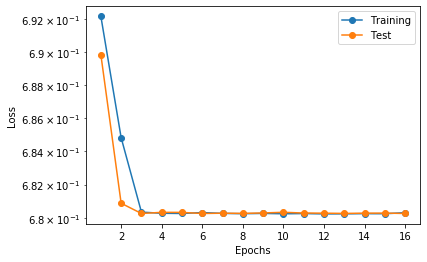

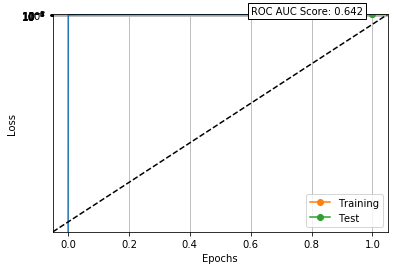

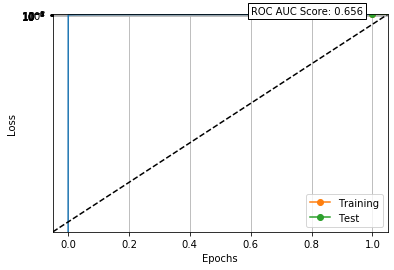

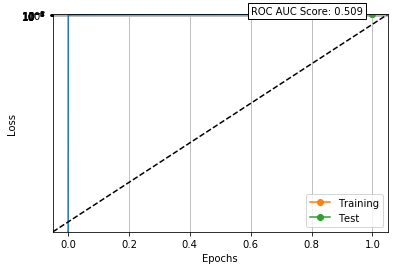

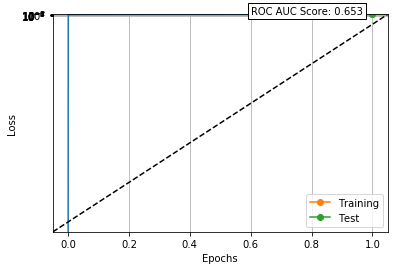

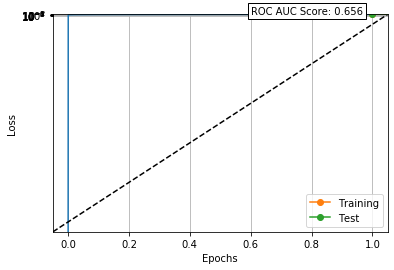

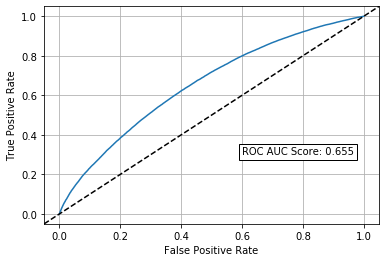

In [94]:
confs = [1, 2, 3, 4, 5, 6]
for conf in confs:
    run_config(conf)

## Customized AUC Score

Compute the customized AUC Score

In [66]:
weight_variables = ["wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
                   "tau_decay_mode_1","tau_decay_mode_2",
                   "mva_dm_1","mva_dm_2"]

df_weights = tree_tt.pandas.df(weight_variables)

# select only rho-rho events
df_weights = df_weights[(df_weights['mva_dm_1']==1) & (df_weights['mva_dm_2']==1) & (df_weights["tau_decay_mode_1"] == 1) & (df_weights["tau_decay_mode_2"] == 1)]


In [67]:
wt_sm = df_weights["wt_cp_sm"]
wt_ps = df_weights["wt_cp_ps"]

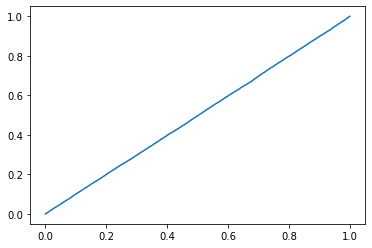

In [68]:
#count all classes
pos_count = len([x for x in y_test if x==1.0])
neg_count = len([x for x in y_test if x==0.0])
#print(pos_count)
#print(neg_count)

#store results here
coords = [(0,0)]
#FPR as horizontal x axis    
fp=0
#TPR as vertical y axis
tp=0

#for each truthful prediction
for truth in y_test:
    if truth == 1:
        tp +=1
    else:
        fp +=1
    #update result
    coords.append((fp, tp))
    
#get tally as separate lists
fp, tp = map(list, zip(*coords))

#calculate tpr and fpr
tpr = np.array(tp)/pos_count
fpr = np.array(fp)/neg_count

#print(tpr)
#print(fpr)
plt.plot(fpr, tpr, '-')

threshold 0.0 finished
threshold 0.010101010101010102 finished
threshold 0.020202020202020204 finished
threshold 0.030303030303030304 finished
threshold 0.04040404040404041 finished
threshold 0.05050505050505051 finished
threshold 0.06060606060606061 finished
threshold 0.07070707070707072 finished
threshold 0.08080808080808081 finished
threshold 0.09090909090909091 finished
threshold 0.10101010101010102 finished
threshold 0.11111111111111112 finished
threshold 0.12121212121212122 finished
threshold 0.13131313131313133 finished
threshold 0.14141414141414144 finished
threshold 0.15151515151515152 finished
threshold 0.16161616161616163 finished
threshold 0.17171717171717174 finished
threshold 0.18181818181818182 finished
threshold 0.19191919191919193 finished
threshold 0.20202020202020204 finished
threshold 0.21212121212121213 finished
threshold 0.22222222222222224 finished
threshold 0.23232323232323235 finished
threshold 0.24242424242424243 finished
threshold 0.25252525252525254 finished

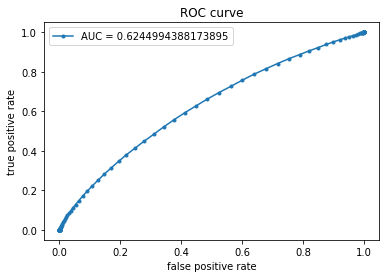

In [78]:
pos_count = len([x for x in y_test if x==1.0])
neg_count = len([x for x in y_test if x==0.0])

tpr = []
fpr = []
for threshold in np.linspace(0, 1, 100):
    true_positives = 0
    false_positives = 0
    for i in range(len(y_proba)):
        prob = y_proba[i]
        true = y_test[i]
        if prob > threshold and true == 1:
            true_positives += 1
        if prob > threshold and true == 0:
            false_positives += 1
    print('threshold', threshold, 'finished')
    tpr.append(np.array(true_positives) / pos_count)
    fpr.append((np.array(false_positives) / neg_count))

from scipy.integrate import simps, trapz

auc = trapz(tpr, fpr) * -1

plt.plot(fpr, tpr, '.-', label='AUC = ' + str(auc))
plt.title('ROC curve')
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.legend()

In [70]:

def custom_auc(y_test, y_proba):
    pass

## Results of the NN:

Without the 4-vectors, without the masses, after 100 epochs: accuracy score = 0.593, ROC AUC score = 0.626

Without the 4-vectors, with the masses, after 100 epochs: accuracy score = 0.593, ROC AUC score = 0.628

With the 4-vectors, without the masses, after 100 epochs, before the rotations: accuracy score = 0.593, ROC AUC score = 0.628

With the 4-vectors, with the masses, after 100 epochs, before the rotations: accuracy score = 0.590, ROC AUC score = 0.626

After the rotations: no results. Hasn't been debugged yet.